In [1]:
from scipy.spatial.distance import cosine
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from langchain_aws import BedrockEmbeddings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lyricsgenius as lg
import joblib

In [19]:
df = pd.read_csv('data/raw/dataset_reduced.csv')

In [361]:
def look_dataset(df) -> None:
    print('First few columns of Dataset:')
    print(df.head())
    print("-----")
    print("Dataset Information:")
    print(df.info())
    print("-----")
    print("Features Summary Statistics")
    print(df.describe())
    

In [362]:
look_dataset(df)

First few columns of Dataset:
   Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again         

### Checking for Possible Duplicates

In [363]:
df['track_id'].value_counts()

track_id
5SuOikwiRyPMVoIQDJUgSV    1
4qPNDBW1i3p13qLCt0Ki3A    1
2qLMf6TuEC3ruGJg4SMMN6    1
4Yo0igmcoNyat1secaH0OD    1
6xKeQgzfjixSUld14qUezm    1
1KHdq8NK9QxnGjdXb55NiG    1
4LbWtBkN82ZRhz9jqzgrb3    1
0X9MxHR1rTkEHDjp95F2OO    1
4ptDJbJl35d7gQfeNteBwp    1
5ivF4eQBqJiVL5IAE9jRyl    1
4mzP5mHkRvGxdhdGdAH7EJ    1
7k9GuJYLp2AzqokyEdwEw2    1
0IktbUcnAGrvD03AWnz3Q8    1
1EzrEOXmMH3G43AXT1y7pA    1
6Vc5wAMmXdKIAM7WUoEb7N    1
01MVOl9KtVTNfFiBU9I7dc    1
5vjLSffimiIP26QG5WcN2K    1
6lfxq3CG4xtTiEg7opyCyx    1
1iJBSr7s7jYXzM8EGcbK5b    1
6CgNoAbFJ4Q4Id4EjtbXlC    1
Name: count, dtype: int64

In [364]:
df[['artists','track_name']].value_counts()

artists                               track_name                      
Jason Mraz;Colbie Caillat             Lucky                               2
A Great Big World;Christina Aguilera  Say Something                       1
Ingrid Michaelson;ZAYN                To Begin Again                      1
Tyrone Wells                          Days I Will Remember                1
Ross Copperman                        Hunger                              1
Landon Pigg                           Falling in Love at a Coffee Shop    1
Kina Grannis                          Can't Help Falling In Love          1
Jason Mraz                            I'm Yours                           1
                                      I Won't Give Up                     1
Gen Hoshino                           Comedy                              1
Andrew Foy;Renee Foy                  At My Worst                         1
Dan Berk                              Solo                                1
Chord Overstreet;

Observe that there are repeated entries for `track_id` and the key(`artists`,  `track_name`)

In [365]:
# Process Dataframe
df = df.iloc[:,1:] 
df = df.drop_duplicates(['artists','track_name']) # Duplicate Values

In [366]:
df

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic
5,01MVOl9KtVTNfFiBU9I7dc,Tyrone Wells,Days I Will Remember,Days I Will Remember,58,214240,False,0.688,0.4810,6,-8.807,1,0.1050,0.2890,0.000000,0.1890,0.6660,98.017,4,acoustic
6,6Vc5wAMmXdKIAM7WUoEb7N,A Great Big World;Christina Aguilera,Is There Anybody Out There?,Say Something,74,229400,False,0.407,0.1470,2,-8.822,1,0.0355,0.8570,0.000003,0.0913,0.0765,141.284,3,acoustic
7,1EzrEOXmMH3G43AXT1y7pA,Jason Mraz,We Sing. We Dance. We Steal Things.,I'm Yours,80,242946,False,0.703,0.4440,11,-9.331,1,0.0417,0.5590,0.000000,0.0973,0.7120,150.960,4,acoustic
8,0IktbUcnAGrvD03AWnz3Q8,Jason Mraz;Colbie Caillat,We Sing. We Dance. We Steal Things.,Lucky,74,189613,False,0.625,0.4140,0,-8.700,1,0.0369,0.2940,0.000000,0.1510,0.6690,130.088,4,acoustic
9,7k9GuJYLp2AzqokyEdwEw2,Ross Copperman,Hunger,Hunger,56,205594,False,0.442,0.6320,1,-6.770,1,0.0295,0.4260,0.004190,0.0735,0.1960,78.899,4,acoustic


In [367]:
df['track_id'].value_counts()

track_id
5SuOikwiRyPMVoIQDJUgSV    1
4mzP5mHkRvGxdhdGdAH7EJ    1
4Yo0igmcoNyat1secaH0OD    1
6xKeQgzfjixSUld14qUezm    1
1KHdq8NK9QxnGjdXb55NiG    1
4LbWtBkN82ZRhz9jqzgrb3    1
0X9MxHR1rTkEHDjp95F2OO    1
4ptDJbJl35d7gQfeNteBwp    1
5ivF4eQBqJiVL5IAE9jRyl    1
7k9GuJYLp2AzqokyEdwEw2    1
4qPNDBW1i3p13qLCt0Ki3A    1
0IktbUcnAGrvD03AWnz3Q8    1
1EzrEOXmMH3G43AXT1y7pA    1
6Vc5wAMmXdKIAM7WUoEb7N    1
01MVOl9KtVTNfFiBU9I7dc    1
5vjLSffimiIP26QG5WcN2K    1
6lfxq3CG4xtTiEg7opyCyx    1
1iJBSr7s7jYXzM8EGcbK5b    1
6CgNoAbFJ4Q4Id4EjtbXlC    1
Name: count, dtype: int64

In [368]:
df[['artists','track_name']].value_counts()

artists                               track_name                      
A Great Big World;Christina Aguilera  Say Something                       1
Ingrid Michaelson;ZAYN                To Begin Again                      1
Tyrone Wells                          Days I Will Remember                1
Ross Copperman                        Hunger                              1
Landon Pigg                           Falling in Love at a Coffee Shop    1
Kina Grannis                          Can't Help Falling In Love          1
Jason Mraz;Colbie Caillat             Lucky                               1
Jason Mraz                            I'm Yours                           1
                                      I Won't Give Up                     1
Gen Hoshino                           Comedy                              1
Andrew Foy;Renee Foy                  At My Worst                         1
Dan Berk                              Solo                                1
Chord Overstreet;

Removing duplicates for the key(`artists`,  `track_name`) also removed duplicates for the `track_id`

### Checking for Possible Missing Values

In [369]:
missing_values = df.isna().sum()
print("Missing values:\n", missing_values)

Missing values:
 track_id            0
artists             0
album_name          0
track_name          0
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64


In [370]:
rows_with_missing_values = df[df.isna().any(axis=1)]
print(rows_with_missing_values)

Empty DataFrame
Columns: [track_id, artists, album_name, track_name, popularity, duration_ms, explicit, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, time_signature, track_genre]
Index: []


All the missing values came from one entry so we should remove this entry

In [371]:
# Process Dataframe
df = df.dropna().reset_index(drop=True)

Variables `popularity` and `duration_ms` could possibly be split into groups!

### Running KMeans for `popularity`

In [372]:
# Scale Data
popularity = df[['popularity']]
popularity_scaler = StandardScaler()
popularity_scaled = popularity_scaler.fit_transform(popularity)

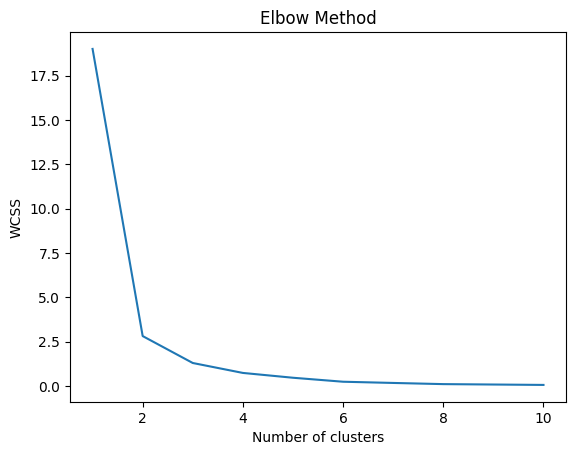

In [373]:
# Determine Number of Clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(popularity_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

By Elbow Method, we choose k = 4

In [374]:
def cluster_popularity(df):
    # Scale Data
    popularity = df[['popularity']]
    popularity_scaler = StandardScaler()
    popularity_scaled = popularity_scaler.fit_transform(popularity)

    # Run K-means with the optimal number of clusters, reorder clusters to popularity
    optimal_clusters = 4 
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=0)
    df['popularity_clusters'] = kmeans.fit_predict(popularity_scaled)
    cluster_means = df.groupby('popularity_clusters')['popularity'].mean()
    sorted_clusters = cluster_means.sort_values().index
    cluster_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted_clusters)}
    df['popularity_clusters'] = df['popularity_clusters'].map(cluster_mapping)

    joblib.dump(scaler, 'data/objects/kmeans_popularity.pkl')
    return df

df = cluster_popularity(df)

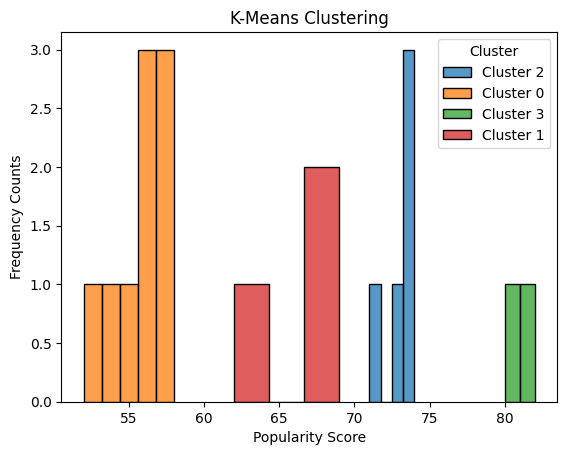

In [375]:
for cluster in df['popularity_clusters'].unique():
    sns.histplot(df[df['popularity_clusters'] == cluster]['popularity'], label=f'Cluster {cluster}')
plt.title('K-Means Clustering')
plt.xlabel('Popularity Score')
plt.ylabel('Frequency Counts')
plt.legend(title='Cluster')
plt.show()

### Running KMeans for `duration_ms`

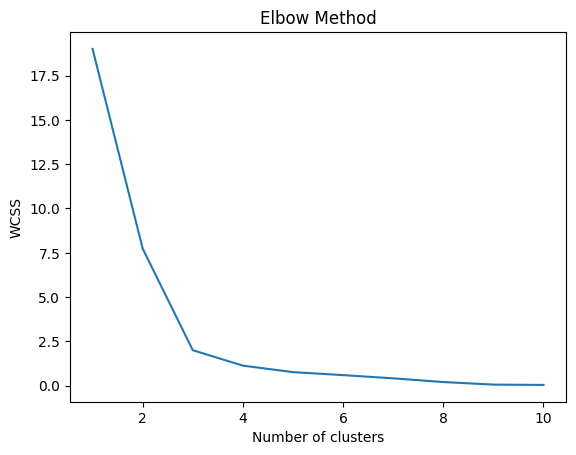

In [376]:
# Scale Data
duration_ms= df[['duration_ms']]
scaler = StandardScaler()
duration_ms_scaled = scaler.fit_transform(duration_ms)

# Determine Number of Clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(duration_ms_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

By Elbow Method, we choose k = 6

In [377]:
def cluster_duration_ms(df):
    duration_ms= df[['duration_ms']]
    scaler = StandardScaler()
    duration_ms_scaled = scaler.fit_transform(duration_ms)

    optimal_clusters = 6 
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=0)
    df['duration_clusters'] = kmeans.fit_predict(duration_ms_scaled)
    cluster_means = df.groupby('duration_clusters')['duration_ms'].mean()
    sorted_clusters = cluster_means.sort_values().index
    cluster_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted_clusters)}
    df['duration_clusters'] = df['duration_clusters'].map(cluster_mapping)
    
    joblib.dump(scaler, 'data/objects/kmeans_duration_ms.pkl')
    return df

df = cluster_duration_ms(df)

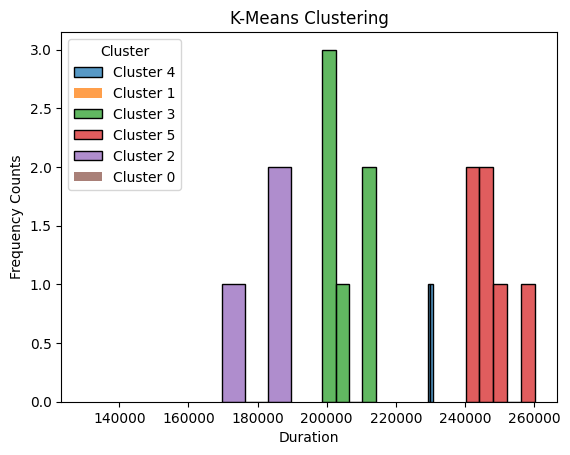

In [378]:
for cluster in df['duration_clusters'].unique():
    sns.histplot(df[df['duration_clusters'] == cluster]['duration_ms'], label=f'Cluster {cluster}')
plt.title('K-Means Clustering')
plt.xlabel('Duration')
plt.ylabel('Frequency Counts')
plt.legend(title='Cluster')
plt.show()

### Scale Numerical Variables

In [379]:
def scale_numerical_features(df):
    # Create a copy of the DataFrame to avoid modifying the original DataFrame
    df_scaled = df.copy()
    
    # Select only numerical columns
    numerical_cols = df_scaled.select_dtypes(include=['float64', 'int64']).columns
    
    # Initialize the scaler
    scaler = StandardScaler()
    df_scaled[numerical_cols] = scaler.fit_transform(df_scaled[numerical_cols])
    joblib.dump(scaler, 'data/objects/scaler.pkl')
    
    return df_scaled

df = scale_numerical_features(df)

### Processing `track_genre` feature
Idea is to convert genre into vector embeddings

In [380]:
def build_embeddings_dictionary(genre_col):
    unique_values = genre_col.unique()
    embeddings_dictionary = {}
    embeddings = BedrockEmbeddings(model_id="amazon.titan-embed-text-v2:0")

    for genre in unique_values:
        embedding = embeddings.embed_query(genre)
        embeddings_dictionary[genre] = embedding
    
    return embeddings_dictionary


In [381]:
def embed_track_genre(df):
    # build embedding dictionary to save cost and speed up process
    embeddings_dictionary = build_embeddings_dictionary(df['track_genre'])

    embeddings_list = []

    for genre in df['track_genre']:
        embedding = embeddings_dictionary[genre]
        embeddings_list.append(embedding)

    embeddings_df = pd.DataFrame(embeddings_list, columns=[f'genre_{i}' for i in range(len(embeddings_list[0]))])
    df_with_embeddings = pd.concat([df, embeddings_df], axis=1)
    return df_with_embeddings

df = embed_track_genre(df)

In [382]:
df.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,genre_1014,genre_1015,genre_1016,genre_1017,genre_1018,genre_1019,genre_1020,genre_1021,genre_1022,genre_1023
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,0.890369,0.591568,False,0.669032,0.585605,-0.773389,...,0.035325,0.023722,-0.008831,0.015922,-0.035325,0.008219,-0.007961,0.033005,-0.05157,0.010894
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,-1.024764,-1.780563,False,-1.129847,-0.991446,-0.773389,...,0.035325,0.023722,-0.008831,0.015922,-0.035325,0.008219,-0.007961,0.033005,-0.05157,0.010894
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,-0.811971,0.010944,False,-1.003363,0.040320,-1.079522,...,0.035325,0.023722,-0.008831,0.015922,-0.035325,0.008219,-0.007961,0.033005,-0.05157,0.010894
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,0.677576,-0.249313,False,-2.211985,-1.560254,-1.079522,...,0.035325,0.023722,-0.008831,0.015922,-0.035325,0.008219,-0.007961,0.033005,-0.05157,0.010894
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,1.847935,-0.339450,False,0.261474,0.489378,-0.467256,...,0.035325,0.023722,-0.008831,0.015922,-0.035325,0.008219,-0.007961,0.033005,-0.05157,0.010894


In [383]:
from src.access_tokens import GENIUS_ACCESS_TOKEN
import string
import re
import requests

In [384]:
def clean_string(input_string):
    translation_table = str.maketrans('', '', string.punctuation)
    no_punctuation_string = input_string.translate(translation_table)
    cleaned_string = re.sub(r'\s+', ' ', no_punctuation_string).strip()
    
    return cleaned_string

def generate_lyrics_url(artist_col, track_name_col):
    # Create URL to Genius
    url = []
    for i in range(len(artist_col)):
        artist_str = artist_col[i].lower().replace(";"," and ")
        track_name_str = track_name_col[i].lower()
        artist_str = clean_string(artist_str)
        track_name_str = clean_string(track_name_str)
        final_str = artist_str + '-' + track_name_str
        final_str = final_str.replace(" ","-").capitalize() + '-lyrics'
        url.append(final_str)
    
    return url

def adjust_lyrics(input_string):
    # Clean Scraped Lyrics
    position = input_string.find("Lyrics")
    if position != -1:
        result_string = input_string[position + len("Lyrics"):]
        result_string = result_string.strip()
    else:
        result_string = input_string
    
    result_string = re.sub(r'\d+Embed$', '', result_string).strip()

    return result_string

def generate_song_lyrics(df):
    # Scrap Genius for Lyrics and add to Dataframe
    genius_access_token = GENIUS_ACCESS_TOKEN
    genius = lg.Genius(genius_access_token)

    artist_col = df['artists']
    track_name_col = df['track_name']
    url_list = generate_lyrics_url(artist_col,track_name_col)
    lyrics_list = []

    for url in url_list:
        try:
            lyrics = genius.lyrics(song_url=url)
            lyrics = adjust_lyrics(lyrics)
        except requests.exceptions.HTTPError as http_err:
            lyrics = "Lyrics not found on Genius"
        finally:
            lyrics_list.append(lyrics)
    
    df['lyrics'] = lyrics_list

    return df

df = generate_song_lyrics(df)

In [385]:
def embed_lyrics(df):
    # embed song lyrics into vector
    # if song lyrics not found, use song name instead
    embeddings_list = []
    embeddings = BedrockEmbeddings()

    for i in range(len(df['lyrics'])):
        lyrics = df['lyrics'][i]
        if  lyrics == "Lyrics not found on Genius":
            embedding = embeddings.embed_query(df['track_name'][i])
        else:
            embedding = embeddings.embed_query(lyrics)
        embeddings_list.append(embedding)

    embeddings_df = pd.DataFrame(embeddings_list, columns=[f'lyrics_{i}' for i in range(len(embeddings_list[0]))])
    df_with_embeddings = pd.concat([df, embeddings_df], axis=1)
    return df_with_embeddings

df = embed_lyrics(df)

In [386]:
df

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,lyrics_1526,lyrics_1527,lyrics_1528,lyrics_1529,lyrics_1530,lyrics_1531,lyrics_1532,lyrics_1533,lyrics_1534,lyrics_1535
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,0.890369,0.591568,False,0.669032,0.585605,-0.773389,...,-0.003464,-0.080566,0.302734,-0.077148,0.237305,0.091797,-0.134766,-0.220703,-0.150391,0.162109
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,-1.024764,-1.780563,False,-1.129847,-0.991446,-0.773389,...,0.333984,0.269531,-0.082520,-0.423828,-0.080566,0.474609,0.226562,-0.273438,-0.789062,-0.718750
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,-0.811971,0.010944,False,-1.003363,0.040320,-1.079522,...,0.186523,0.373047,-0.202148,-0.164062,0.051758,-0.010071,-0.201172,-0.261719,-0.189453,0.216797
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,0.677576,-0.249313,False,-2.211985,-1.560254,-1.079522,...,0.120605,0.071289,0.281250,-0.087402,0.304688,0.300781,0.190430,-0.054199,-0.233398,0.075195
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,1.847935,-0.339450,False,0.261474,0.489378,-0.467256,...,-0.147461,0.073242,-0.007202,-0.035889,0.380859,0.080078,-0.016113,-0.322266,-0.482422,0.163086
5,01MVOl9KtVTNfFiBU9I7dc,Tyrone Wells,Days I Will Remember,Days I Will Remember,-0.705575,0.110856,False,0.753355,0.692524,0.757277,...,0.137695,0.139648,-0.104492,-0.221680,-0.061768,-0.005920,0.101074,-0.196289,-0.146484,0.265625
6,6Vc5wAMmXdKIAM7WUoEb7N,A Great Big World;Christina Aguilera,Is There Anybody Out There?,Say Something,0.996765,0.554518,False,-1.221196,-1.093019,-0.467256,...,-0.155273,0.108398,0.001556,0.005890,-0.075195,0.106934,-0.145508,-0.271484,-0.429688,-0.110352
7,1EzrEOXmMH3G43AXT1y7pA,Jason Mraz,We Sing. We Dance. We Steal Things.,I'm Yours,1.635142,0.950946,False,0.858758,0.494724,2.287943,...,-0.340186,0.093093,-0.141180,-0.091112,0.125884,0.203779,-0.015053,-0.113648,-0.338242,0.185516
8,0IktbUcnAGrvD03AWnz3Q8,Jason Mraz;Colbie Caillat,We Sing. We Dance. We Steal Things.,Lucky,0.996765,-0.609862,False,0.310662,0.334346,-1.079522,...,-0.138261,-0.066673,-0.379570,-0.167929,0.380971,0.147093,0.299346,-0.015352,-0.265593,0.111268
9,7k9GuJYLp2AzqokyEdwEw2,Ross Copperman,Hunger,Hunger,-0.918368,-0.142173,False,-0.975256,1.499761,-0.773389,...,-0.076660,0.314453,0.271484,-0.096680,-0.003403,0.341797,-0.075195,-0.429688,-0.578125,0.216797
